In [63]:
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
env = gym.make("Pendulum-v1")

## Un premier Algorithme REINFORCE

Définition des hyperparamètres

In [64]:
## Hyperparametres
env.reset()

learning_rate = 2**(-1)
gamma = 0.95
sigma = 0.1
num_episodes = 1200
max_steps = 200


np.random.seed(0)
theta = np.random.randn(env.observation_space.shape[0])

# {'learning_rate': 0.003, 'gamma': 0.95, 'sigma': 0.1}


Définition de la politique et fonction de mise à jour des gains (récompenses cumulées)

-La politique est une fonction linéaire des caractéristiques de l’état, pondérées par les composantes de theta

-sigma est l'écart-type de la distribution gaussienne, servant à ajouter de l’exploration aléatoire

In [65]:
##Politique (distribution normale car l'espace des actions est continu)
def policy(state, theta):
    return np.dot(state, theta)

def choose_action(state, theta):
    mean_action = policy(state, theta)
    action = np.random.normal(mean_action, sigma)
    return np.clip(action, env.action_space.low[0], env.action_space.high[0])

##discounted returns
def compute_returns(rewards):
    returns = np.zeros_like(rewards, dtype=float)
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns

Implémentation de REINFORCE

[  1012.25120702  -9989.38155174 239780.97873798]


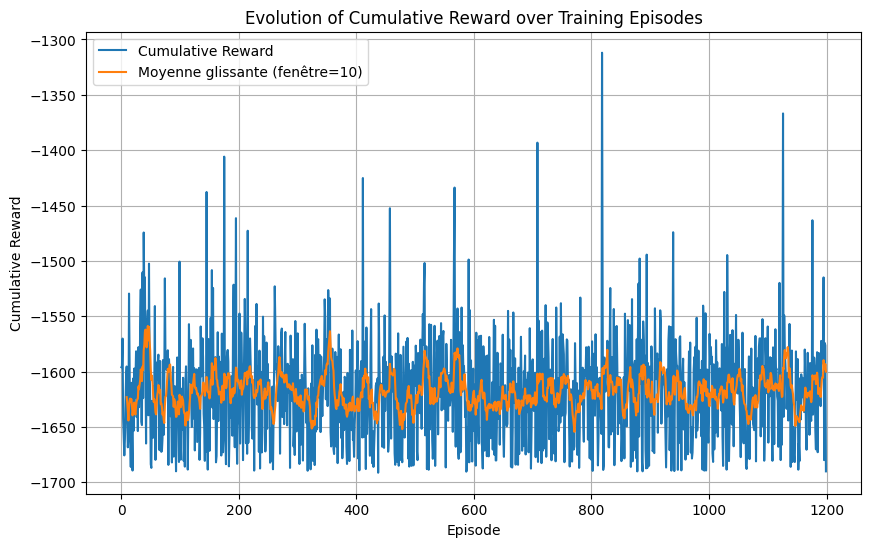

In [66]:
##REINFORCE
def reinforce(env, theta, learning_rate, gamma, sigma, num_episodes):
    cumulative_rewards = []

    for episode in range(num_episodes):
        state = env.reset()[0]
        states, actions, rewards = deque(), deque(), deque()
        # Generation d'un épisode complet
        truncated = False
        for step in range(max_steps):
            action = choose_action(state, theta)
            next_state, reward, _, truncated, _ = env.step([action])
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if truncated:
                break
        returns = compute_returns(np.array(rewards))
        # descente de gradient
        for t in range(len(states)):
            state = states[t]
            action = actions[t]
            G = returns[t]
            mean_action = policy(state, theta)
            grad_log_policy = (action - mean_action) / (sigma ** 2) * state
            grad_update = learning_rate * gamma ** t * G * grad_log_policy
            theta += np.clip(grad_update, -1, 1)
        cumulative_rewards.append(sum(rewards))
    return theta, cumulative_rewards


optimal_theta, cumulative_rewards = reinforce(env, theta, learning_rate, gamma, sigma, num_episodes)
print(optimal_theta, )

##affichage
plt.figure(figsize=(10, 6))
plt.plot(cumulative_rewards, label='Cumulative Reward')
episodes = np.arange(len(cumulative_rewards))
window = 10
moving_avg = np.convolve(cumulative_rewards, np.ones(window)/window, mode='valid')
plt.plot(episodes[window-1:], moving_avg, label="Moyenne glissante (fenêtre=10)")
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Evolution of Cumulative Reward over Training Episodes')
plt.legend()
plt.grid(True)
plt.show()

## REINFORCEMENT with Baseline

Une première Baseline : moyenne des retours passés

In [67]:
# Hyperparametres
env.reset()

LEARNING_RATE = 2**(-1)
GAMMA = 0.95
SIGMA = 0.1
SIGMA_DECREASE_RATE = 0.95
SIGMA_MIN = 0.02
MAX_STEPS = 200
NUM_EPISODES = 1200



def policy_baseline(state, theta):
    return np.dot(state, theta)

def choose_action_baseline(state, theta, sigma=sigma):
    mean_action = policy(state, theta)
    action = np.random.normal(mean_action, sigma)
    return np.clip(action, env.action_space.low[0], env.action_space.high[0])



def compute_returns_baseline(rewards, gamma):
    returns = np.zeros_like(rewards, dtype=float)
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns


def reinforce_linear_with_baseline(env, theta, learning_rate, gamma, sigma, num_episodes,
                                   sigma_decrease_rate, sigma_min, max_steps):

    cumulative_rewards = []
    current_sigma = sigma

    for episode in range(num_episodes):
        state, _ = env.reset()
        states, actions, rewards = deque(), deque(), deque()
        for step in range(max_steps):
            action = choose_action_baseline(state, theta, current_sigma)
            next_state, reward, terminated, truncated, _ = env.step([action])
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if terminated or truncated:
                break

        returns = compute_returns_baseline(np.array(rewards), gamma)
        baseline = np.mean(returns)  # baseline: moyenne des retours passés

        for t in range(len(states)):
            s = states[t]
            a = actions[t]
            G = returns[t]
            advantage = G - baseline
            mean_action = policy(s, theta)
            grad_log_policy = ((a - mean_action) / (current_sigma ** 2)) * s
            grad_update = learning_rate * (gamma ** t) * advantage * grad_log_policy
            theta += np.clip(grad_update, -1, 1)
        cumulative_rewards.append(np.sum(rewards))
        current_sigma = max(sigma_min, current_sigma * sigma_decrease_rate)
    return theta, cumulative_rewards


optimal_theta, cumulative_rewards = reinforce_linear_with_baseline(
    env, theta, LEARNING_RATE, GAMMA, SIGMA, NUM_EPISODES,
    SIGMA_DECREASE_RATE, SIGMA_MIN, MAX_STEPS)


print("Optimal Theta:", optimal_theta)

Optimal Theta: [  1560.25120702  27270.61844826 332584.97873798]


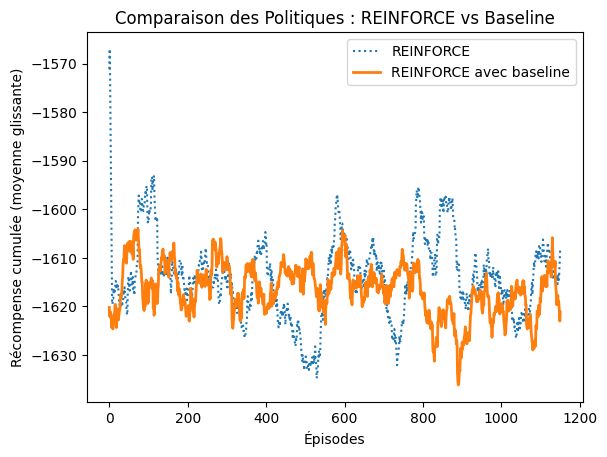

In [68]:
theta0 = np.random.randn(env.observation_space.shape[0])
np.random.seed(0)

optimal_theta, train_rewards_reinforce = reinforce(env, theta0, learning_rate, gamma, sigma, num_episodes)


optimal_theta_baseline, train_rewards_reinforce_baseline = reinforce_linear_with_baseline(
    env, theta0, LEARNING_RATE, GAMMA, SIGMA, NUM_EPISODES,
    SIGMA_DECREASE_RATE, SIGMA_MIN, MAX_STEPS)

# moyenne glissante (fenêtre de 50 épisodes)
def smooth_curve(data, window=50):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.plot(smooth_curve(train_rewards_reinforce), label="REINFORCE", linestyle="dotted")
plt.plot(smooth_curve(train_rewards_reinforce_baseline), label="REINFORCE avec baseline", linewidth=2)

plt.xlabel("Épisodes")
plt.ylabel("Récompense cumulée (moyenne glissante)")
plt.title("Comparaison des Politiques : REINFORCE vs Baseline")
plt.legend()
plt.show()

## Optimisation des hyperparamètres

In [69]:
from itertools import product

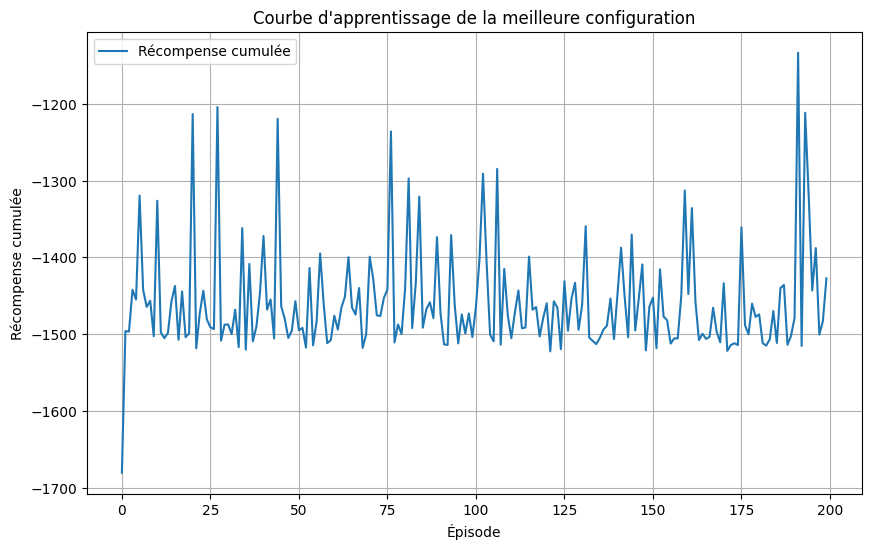

Meilleure configuration : {'learning_rate': 0.05, 'gamma': 0.9, 'sigma': 0.1, 'num_episodes': 200, 'sigma_decrease_rate': 0.99, 'sigma_min': 0.05, 'max_step': 200}


In [70]:
env.reset()

hyperparams_grid = {
    "learning_rate": [0.05,0.01,0.005],
    "gamma": [0.9,0.95],
    "sigma":  [0.1,0.01,0.005],
    "num_episodes": [200],
    "sigma_decrease_rate": [0.95,0.99],
    "sigma_min":  [0.05,0.01,0.005],
    "max_step": [200]
}

def grid_search_with_baseline(env, hyperparams_grid):
    best_reward = -np.inf
    best_params = None
    best_theta = None
    best_rewards_curve = None
    results = []

    keys = list(hyperparams_grid.keys())
    values = [hyperparams_grid[key] for key in keys]
    for idx, combination in enumerate(product(*values)):
        params = dict(zip(keys, combination))
        theta_init = np.random.randn(env.observation_space.shape[0])
        theta_opt, rewards = reinforce_linear_with_baseline(
            env,
            theta_init,
            params["learning_rate"],
            params["gamma"],
            params["sigma"],
            params["num_episodes"],
            params["sigma_decrease_rate"],
            params["sigma_min"],
            params["max_step"]
        )
        avg_reward = np.mean(rewards[-10:])
        results.append({
            "params": params,
            "avg_reward": avg_reward,
            "theta": theta_opt,
            "rewards": rewards
        })
        if avg_reward > best_reward:
            best_reward = avg_reward
            best_params = params
            best_theta = theta_opt
            best_rewards_curve = rewards
    episodes = np.arange(len(best_rewards_curve))
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, best_rewards_curve, label="Récompense cumulée")
    plt.xlabel("Épisode")
    plt.ylabel("Récompense cumulée")
    plt.title("Courbe d'apprentissage de la meilleure configuration")
    plt.legend()
    plt.grid(True)
    plt.show()
    return best_params, best_theta, results

best_params, best_theta, results = grid_search_with_baseline(env, hyperparams_grid)
print("Meilleure configuration :", best_params)

Hyperparamètres optimaux

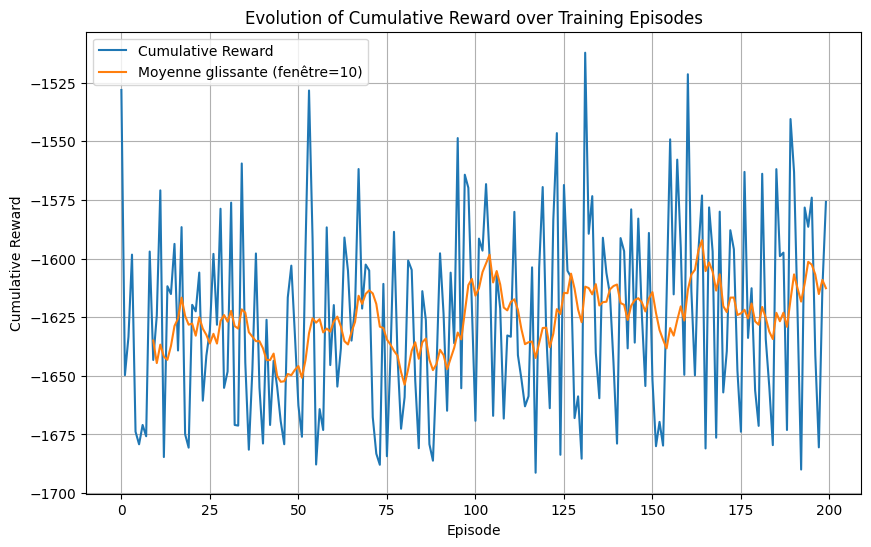

In [71]:
env.reset()

LEARNING_RATE = 0.001
GAMMA = 0.95
SIGMA = 0.005              # initial exploration noise
SIGMA_DECREASE_RATE = 0.95
SIGMA_MIN = 0.01
MAX_STEPS = 200
NUM_EPISODES = 200

optimal_theta, cumulative_rewards = reinforce_linear_with_baseline(
    env, theta, LEARNING_RATE, GAMMA, SIGMA, NUM_EPISODES,
    SIGMA_DECREASE_RATE, SIGMA_MIN, MAX_STEPS)

##Affichage
plt.figure(figsize=(10, 6))
plt.plot(cumulative_rewards, label='Cumulative Reward')
episodes = np.arange(len(cumulative_rewards))
window = 10
moving_avg = np.convolve(cumulative_rewards, np.ones(window)/window, mode='valid')
plt.plot(episodes[window-1:], moving_avg, label="Moyenne glissante (fenêtre=10)")
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Evolution of Cumulative Reward over Training Episodes')
plt.legend()
plt.grid(True)
plt.show()

## Comparaison avec et sans baseline

In [72]:

def policy(state, theta):
    return np.dot(state, theta)

def choose_action(state, theta, sigma):
    mean_action = policy(state, theta)
    action = np.random.normal(mean_action, sigma)
    return np.clip(action, env.action_space.low[0], env.action_space.high[0])
def compute_returns(rewards, gamma):
    returns = np.zeros_like(rewards, dtype=float)
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns
def policy_baseline(state, theta):
    return np.dot(state, theta)

def choose_action_baseline(state, theta, sigma):
    mean_action = policy_baseline(state, theta)
    action = np.random.normal(mean_action, sigma)
    return np.clip(action, env.action_space.low[0], env.action_space.high[0])

def compute_returns_baseline(rewards, gamma):
    returns = np.zeros_like(rewards, dtype=float)
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns


In [73]:

def compare_reinforce_algorithms(env, theta, learning_rate, gamma, sigma, num_episodes,
                                 sigma_decrease_rate, sigma_min, max_steps):

    def reinforce(env, theta, learning_rate, gamma, sigma, num_episodes):
        theta=theta0
        cumulative_rewards = []

        for episode in range(num_episodes):
            state = env.reset()[0]
            states, actions, rewards = deque(), deque(), deque()

            for step in range(max_steps):
                action = choose_action(state, theta, sigma)
                next_state, reward, _, truncated, _ = env.step([action])
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                state = next_state
                if truncated:
                    break

            returns = compute_returns(np.array(rewards), gamma)
            for t in range(len(states)):
                state = states[t]
                action = actions[t]
                G = returns[t]
                mean_action = policy(state, theta)
                grad_log_policy = (action - mean_action) / (sigma ** 2) * state
                grad_update = learning_rate * gamma ** t * G * grad_log_policy
                theta += np.clip(grad_update, -1, 1)

            cumulative_rewards.append(sum(rewards))

        return cumulative_rewards

    def reinforce_with_baseline(env, theta, learning_rate, gamma, sigma, num_episodes,
                                sigma_decrease_rate, sigma_min, max_steps):
        theta = theta0
        cumulative_rewards = []
        current_sigma = sigma
        for episode in range(num_episodes):
            state = env.reset()[0]
            states, actions, rewards = deque(), deque(), deque()
            for step in range(max_steps):
                action = choose_action(state, theta, current_sigma)
                next_state, reward, _, truncated, _ = env.step([action])
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                state = next_state
                if truncated:
                    break
            returns = compute_returns(np.array(rewards), gamma)
            baseline = np.mean(returns)
            for t in range(len(states)):
                state = states[t]
                action = actions[t]
                G = returns[t]
                advantage = G - baseline
                mean_action = policy(state, theta)
                grad_log_policy = ((action - mean_action) / (current_sigma ** 2)) * state
                grad_update = learning_rate * (gamma ** t) * advantage * grad_log_policy
                theta += np.clip(grad_update, -1, 1)
            cumulative_rewards.append(sum(rewards))
            current_sigma = max(sigma_min, current_sigma * sigma_decrease_rate)
        return cumulative_rewards


    rewards_no_baseline = reinforce(env, np.copy(theta), learning_rate, gamma, sigma, num_episodes)
    rewards_with_baseline = reinforce_with_baseline(env, np.copy(theta), learning_rate, gamma, sigma, num_episodes,
                                                    sigma_decrease_rate, sigma_min, max_steps)

    plt.figure(figsize=(10, 6))
    plt.plot(rewards_no_baseline, label="REINFORCE sans baseline")
    plt.plot(rewards_with_baseline, label="REINFORCE avec baseline")

    window = 10
    moving_avg_no_baseline = np.convolve(rewards_no_baseline, np.ones(window) / window, mode='valid')
    moving_avg_with_baseline = np.convolve(rewards_with_baseline, np.ones(window) / window, mode='valid')

    plt.plot(np.arange(window - 1, num_episodes), moving_avg_no_baseline, label="Moyenne glissante sans baseline")
    plt.plot(np.arange(window - 1, num_episodes), moving_avg_with_baseline, label="Moyenne glissante avec baseline")

    plt.xlabel('Épisode')
    plt.ylabel('Récompense cumulée')
    plt.title('Comparaison de REINFORCE avec et sans baseline')
    plt.legend()
    plt.grid(True)
    plt.show()


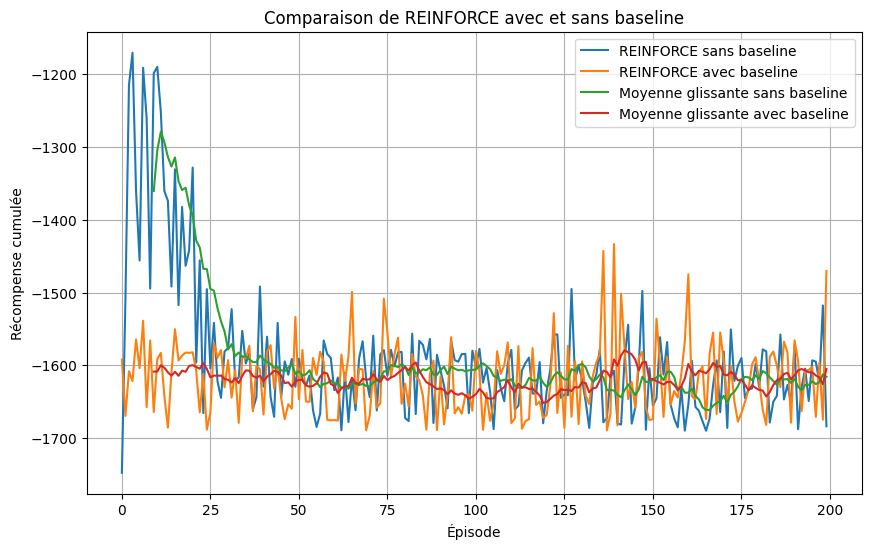

In [74]:
env.reset()
theta0 = np.random.randn(env.observation_space.shape[0])
LEARNING_RATE = 0.05
GAMMA = 0.95
SIGMA = 0.1
NUM_EPISODES = 200
SIGMA_DECREASE_RATE = 0.95
SIGMA_MIN = 0.05
MAX_STEPS = 200
compare_reinforce_algorithms(env, theta0, LEARNING_RATE, GAMMA, SIGMA, NUM_EPISODES,
                             SIGMA_DECREASE_RATE, SIGMA_MIN, MAX_STEPS)

## Comparaison avec Baseline paramétrée

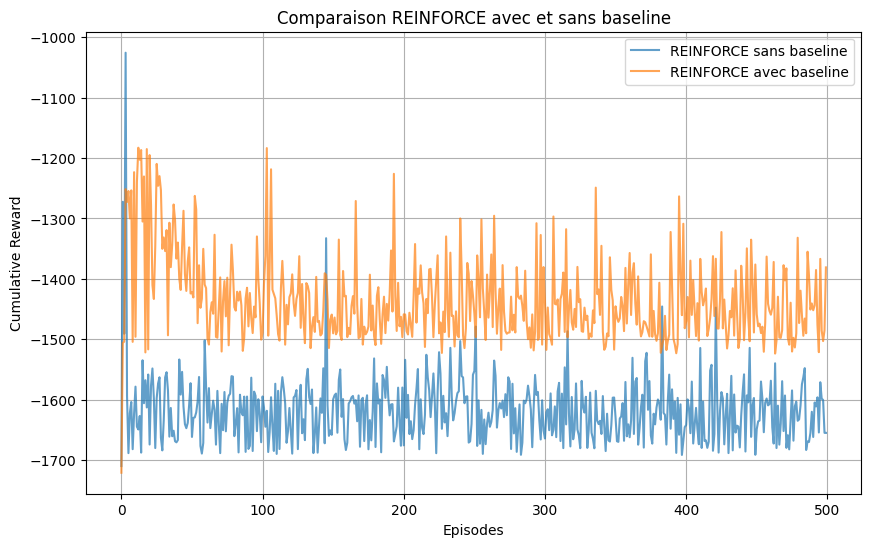

In [75]:
env.reset()

# Hyperparamètres
learning_rate = 0.05
gamma = 0.95
sigma = 0.1
num_episodes = 500
sigma_decrease_rate = 0.95
sigma_min = 0.02
max_steps = 200

# initialisation
theta0 = np.random.randn(env.observation_space.shape[0])
baseline = 0

def reinforce_baseline_parametre(env, theta, learning_rate, gamma, sigma, num_episodes, use_baseline=False):
    cumulative_rewards = []
    global baseline

    for episode in range(num_episodes):
        state = env.reset()[0]
        states, actions, rewards = deque(), deque(), deque()

        for step in range(max_steps):
            action = policy_action(theta, state, sigma)
            next_state, reward, _, truncated, _ = env.step([action])
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if truncated:
                break

        returns = np.zeros_like(rewards, dtype=float)
        G = 0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + gamma * G
            returns[t] = G

        if use_baseline:
            baseline = 0.9 * baseline + 0.1 * np.mean(returns)  # mise à jour de la baseline

        for t in range(len(states)):
            state = states[t]
            action = actions[t]
            G = returns[t]
            advantage = G - baseline if use_baseline else G
            mean_action = np.dot(theta, state)
            grad_log_policy = (action - mean_action) / (sigma ** 2) * state
            grad_update = learning_rate * gamma ** t * advantage * grad_log_policy
            theta += np.clip(grad_update, -1, 1)

        cumulative_rewards.append(np.sum(rewards))

    return cumulative_rewards


rewards_no_baseline = reinforce_baseline_parametre(env, theta0.copy(), learning_rate, gamma, sigma, num_episodes, use_baseline=False)
rewards_with_baseline = reinforce_baseline_parametre(env, theta0.copy(), learning_rate, gamma, sigma, num_episodes, use_baseline=True)

# affichage
plt.figure(figsize=(10, 6))
plt.plot(rewards_no_baseline, label="REINFORCE sans baseline", alpha=0.7)
plt.plot(rewards_with_baseline, label="REINFORCE avec baseline", alpha=0.7)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Comparaison REINFORCE avec et sans baseline")
plt.legend()
plt.grid()
plt.show()


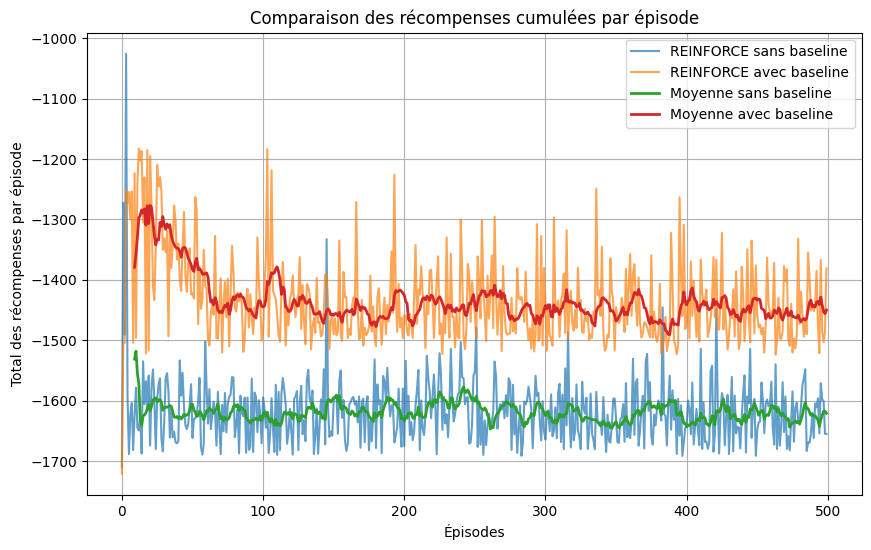

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(rewards_no_baseline, label="REINFORCE sans baseline", alpha=0.7)
plt.plot(rewards_with_baseline, label="REINFORCE avec baseline", alpha=0.7)


window = 10
moving_avg_no_baseline = np.convolve(rewards_no_baseline, np.ones(window) / window, mode='valid')
moving_avg_with_baseline = np.convolve(rewards_with_baseline, np.ones(window) / window, mode='valid')

plt.plot(range(window-1, len(rewards_no_baseline)), moving_avg_no_baseline, label="Moyenne sans baseline", linewidth=2)
plt.plot(range(window-1, len(rewards_with_baseline)), moving_avg_with_baseline, label="Moyenne avec baseline", linewidth=2)
plt.xlabel("Épisodes")
plt.ylabel("Total des récompenses par épisode")
plt.title("Comparaison des récompenses cumulées par épisode")
plt.legend()
plt.grid(True)
plt.show()


## Comparaison avec learning rate qui diminue

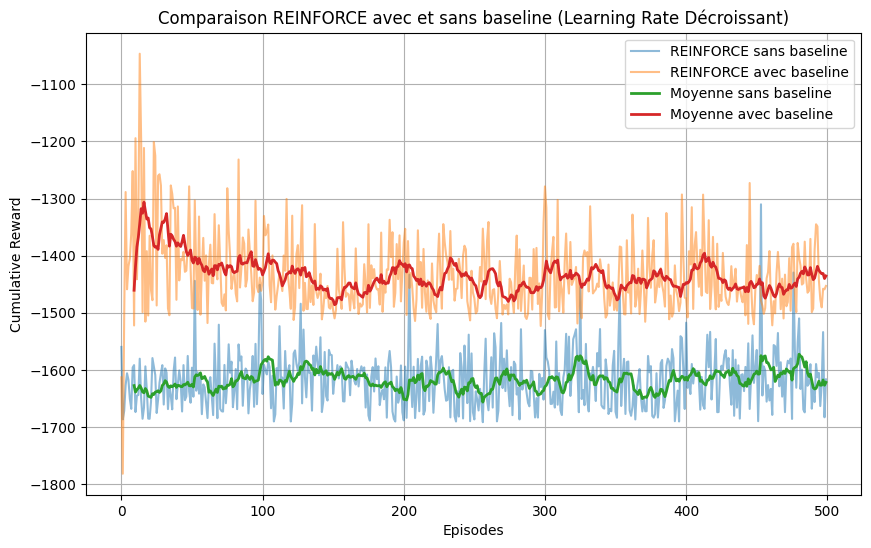

In [77]:
env.reset()

# Hyperparamètres
initial_learning_rate = 0.05
gamma = 0.95
sigma = 0.1
num_episodes = 500
sigma_decrease_rate = 0.95
sigma_min = 0.02
max_steps = 200

# initialisation
theta0 = np.random.randn(env.observation_space.shape[0])
baseline = 0

def reinforce_baseline_parametre(env, theta, learning_rate, gamma, sigma, num_episodes, use_baseline=False):
    cumulative_rewards = []
    global baseline

    for episode in range(num_episodes):
        state = env.reset()[0]
        states, actions, rewards = deque(), deque(), deque()

        for step in range(max_steps):
            action = policy_action(theta, state, sigma)
            next_state, reward, _, truncated, _ = env.step([action])
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if truncated:
                break

        returns = np.zeros_like(rewards, dtype=float)
        G = 0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + gamma * G
            returns[t] = G

        if use_baseline:
            baseline = 0.9 * baseline + 0.1 * np.mean(returns)

        for t in range(len(states)):
            state = states[t]
            action = actions[t]
            G = returns[t]
            advantage = G - baseline if use_baseline else G
            mean_action = np.dot(theta, state)
            grad_log_policy = (action - mean_action) / (sigma ** 2) * state
            grad_update = learning_rate * (gamma ** t) * advantage * grad_log_policy
            theta += np.clip(grad_update, -1, 1)

        cumulative_rewards.append(np.sum(rewards))

        learning_rate = max(0.001, learning_rate * 0.99)

    return cumulative_rewards


rewards_no_baseline = reinforce_baseline_parametre(env, theta0.copy(), initial_learning_rate, gamma, sigma, num_episodes, use_baseline=False)
rewards_with_baseline = reinforce_baseline_parametre(env, theta0.copy(), initial_learning_rate, gamma, sigma, num_episodes, use_baseline=True)


plt.figure(figsize=(10, 6))
plt.plot(rewards_no_baseline, label="REINFORCE sans baseline", alpha=0.5)
plt.plot(rewards_with_baseline, label="REINFORCE avec baseline", alpha=0.5)
window = 10
smoothed_no_baseline = np.convolve(rewards_no_baseline, np.ones(window)/window, mode='valid')
smoothed_with_baseline = np.convolve(rewards_with_baseline, np.ones(window)/window, mode='valid')

plt.plot(range(window-1, len(rewards_no_baseline)), smoothed_no_baseline, label="Moyenne sans baseline", linewidth=2)
plt.plot(range(window-1, len(rewards_with_baseline)), smoothed_with_baseline, label="Moyenne avec baseline", linewidth=2)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Comparaison REINFORCE avec et sans baseline (Learning Rate Décroissant)")
plt.legend()
plt.grid()
plt.show()


## Comparaison avec gamma qui diminue

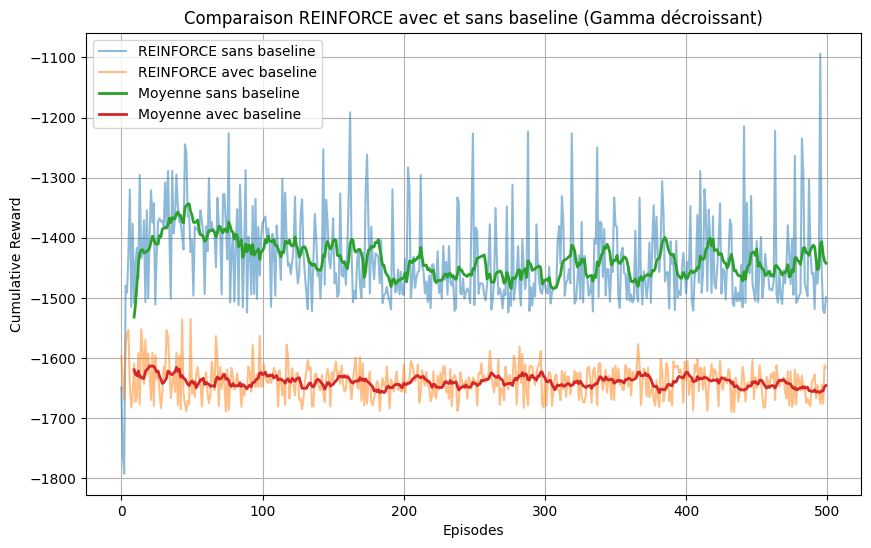

In [78]:
env.reset()

# Hyperparamètres
learning_rate = 0.05
initial_gamma = 0.95
sigma = 0.1
num_episodes = 500
sigma_decrease_rate = 0.95
sigma_min = 0.02
max_steps = 200

theta0 = np.random.randn(env.observation_space.shape[0])
baseline = 0

def reinforce_baseline_parametre(env, theta, learning_rate, gamma, sigma, num_episodes, use_baseline=False):
    cumulative_rewards = []
    global baseline

    for episode in range(num_episodes):
        state = env.reset()[0]
        states, actions, rewards = deque(), deque(), deque()

        for step in range(max_steps):
            action = policy_action(theta, state, sigma)
            next_state, reward, _, truncated, _ = env.step([action])
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if truncated:
                break

        returns = np.zeros_like(rewards, dtype=float)
        G = 0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + gamma * G
            returns[t] = G

        if use_baseline:
            baseline = 0.9 * baseline + 0.1 * np.mean(returns)

        for t in range(len(states)):
            state = states[t]
            action = actions[t]
            G = returns[t]
            advantage = G - baseline if use_baseline else G
            mean_action = np.dot(theta, state)
            grad_log_policy = (action - mean_action) / (sigma ** 2) * state
            grad_update = learning_rate * (gamma ** t) * advantage * grad_log_policy
            theta += np.clip(grad_update, -1, 1)

        cumulative_rewards.append(np.sum(rewards))

        gamma = max(0.5, gamma * 0.995)

    return cumulative_rewards

rewards_no_baseline = reinforce_baseline_parametre(env, theta0.copy(), learning_rate, initial_gamma, sigma, num_episodes, use_baseline=False)
rewards_with_baseline = reinforce_baseline_parametre(env, theta0.copy(), learning_rate, initial_gamma, sigma, num_episodes, use_baseline=True)

plt.figure(figsize=(10, 6))
plt.plot(rewards_no_baseline, label="REINFORCE sans baseline", alpha=0.5)
plt.plot(rewards_with_baseline, label="REINFORCE avec baseline", alpha=0.5)
window = 10
smoothed_no_baseline = np.convolve(rewards_no_baseline, np.ones(window)/window, mode='valid')
smoothed_with_baseline = np.convolve(rewards_with_baseline, np.ones(window)/window, mode='valid')

plt.plot(range(window-1, len(rewards_no_baseline)), smoothed_no_baseline, label="Moyenne sans baseline", linewidth=2)
plt.plot(range(window-1, len(rewards_with_baseline)), smoothed_with_baseline, label="Moyenne avec baseline", linewidth=2)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Comparaison REINFORCE avec et sans baseline (Gamma décroissant)")
plt.legend()
plt.grid()
plt.show()
